# Matrix Factorization 1

* 최근 추천 시스템의 근간인 Matrix Factoization 모델에 대해서 알아 봅니다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

## 상호작용(Iteraction)

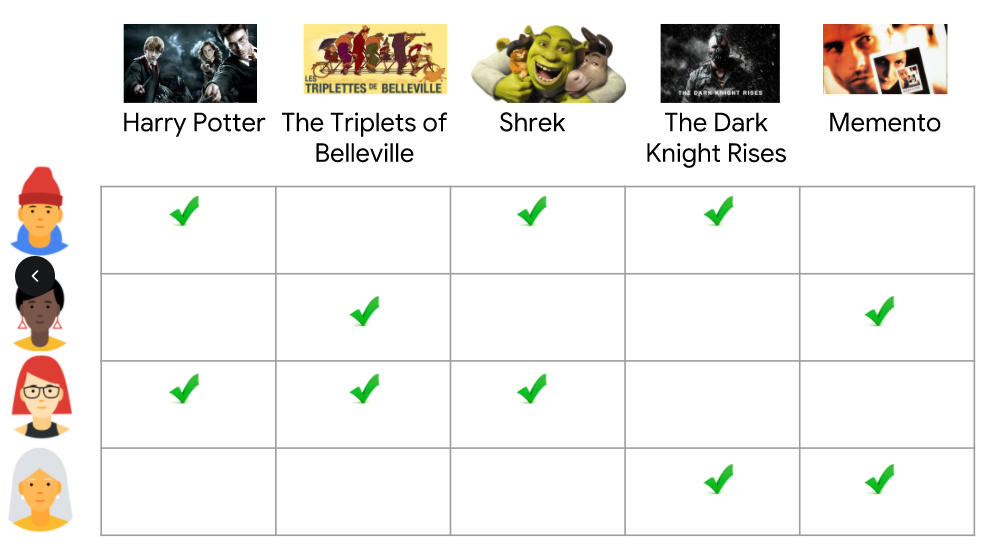

**Iteraction Matrix**

예제) MovieLen 100K 데이터셋에서 Interaction Matrix를 만들어봅니다.

평졈 호불호가 분명한 영화 몇 개와 사용자 몇 명을 뽑아 상호 작용 행렬의 예를 들어 봅니다.

In [3]:
# 평점의 표준편차가 1이상이고 (호불호가 분명한 것을 가져오기 위함입니다), 
# 제목이 20글자 이내인(좀더 많은 내용을 화면에 표시 위함입니다)
# 영화중 평점수 순으로 상위 6개의 영화를 가져옵니다.
df_movie.loc[
    df_ratings.groupby('item id').filter(lambda x: x['rating'].std() > 1)['item id'].value_counts()\
            .pipe(lambda x: x.loc[x.index.map(df_movie['movie title']).str.len() < 20]).head(6).index
]

,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item id,,,,,,,,,,,,,,,,,,,,,
294,Liar Liar (1997),21-Mar-1997,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
288,Scream (1996),20-Dec-1996,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
56,Pulp Fiction (1994),01-Jan-1994,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
69,Forrest Gump (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
748,"Saint, The (1997)",14-Mar-1997,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
118,Twister (1996),10-May-1996,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
item_index = df_ratings.groupby('item id').filter(lambda x: x['rating'].std() > 1)['item id'].value_counts()\
            .pipe(lambda x: x.loc[x.index.map(df_movie['movie title']).str.len() < 20]).head(6).index

# 평점의 표준편차가 1이 넘고 선정한 영화를 3건 넘게 시청한 사용자 중 평점순으로 10명을 뽑습니다.
df_user.loc[
    df_ratings.groupby('user id').filter(lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3)['user id'].value_counts().head(10).index
]

,age,gender,occupation,zip code
user id,,,,
13,47,M,educator,29206
276,21,M,student,95064
416,20,F,student,92626
303,19,M,student,14853
846,27,M,lawyer,47130
7,57,M,administrator,91344
94,26,M,student,71457
682,23,M,programmer,55128
293,24,M,writer,60804


In [5]:
item_index = df_ratings.groupby('item id').filter(lambda x: x['rating'].std() > 1)['item id'].value_counts()\
            .pipe(lambda x: x.loc[x.index.map(df_movie['movie title']).str.len() < 20]).head(6).index
user_index = df_ratings.groupby('user id').filter(lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3)['user id'].value_counts().head(10).index

# 피벗을 통해 사용자 × 영화로 구성된 상호작용행렬을 만듭니다.
df_interaction = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
].join(df_movie['movie title'], on='item id')\
.join(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1).rename('user'), on='user id')\
.pivot(index='user',  columns='movie title', values='rating').sort_index().sort_index(axis=1)
df_interaction

movie title,Forrest Gump (1994),Liar Liar (1997),Pulp Fiction (1994),"Saint, The (1997)",Scream (1996),Twister (1996)
user,,,,,,
19/M/student,5.0,4.0,5.0,2.0,4.0,2.0
20/F/student,4.0,4.0,5.0,4.0,5.0,2.0
21/M/student,4.0,4.0,5.0,3.0,4.0,3.0
23/M/programmer,4.0,3.0,4.0,3.0,4.0,NaN
24/M/writer,3.0,2.0,4.0,2.0,3.0,NaN
26/M/student,3.0,NaN,5.0,NaN,3.0,3.0
27/M/lawyer,5.0,3.0,5.0,3.0,4.0,NaN
29/M/programmer,5.0,3.0,5.0,NaN,4.0,4.0
47/M/educator,4.0,2.0,5.0,4.0,1.0,4.0


In [6]:
df_movie.loc[
    item_index
].T

item id,294,288,56,69,748,118
movie title,Liar Liar (1997),Scream (1996),Pulp Fiction (1994),Forrest Gump (1994),"Saint, The (1997)",Twister (1996)
release date,21-Mar-1997,20-Dec-1996,01-Jan-1994,01-Jan-1994,14-Mar-1997,10-May-1996
unknown,0,0,0,0,0,0
Action,0,0,0,0,1,1
Adventure,0,0,0,0,0,1
Animation,0,0,0,0,0,0
Children's,0,0,0,0,0,0
Comedy,1,0,0,1,0,0
Crime,0,0,1,0,0,0
Documentary,0,0,0,0,0,0


# Matrix Factorization

상호작용을 모델링하기 위한 모델

> Sparsity가 큰 Sparse Matrix입니다.

> 크기는 User와 Item의 수의 곱입니다. 

$N_{user}×N_{item}$의 상호작용 행렬(Matrix)을 

$N_{user}×Rank$사용자 행렬과 $N_{item}×Rank$아이템 행렬 두 개의 행렬곱으로 분해하는 모델입니다.

$Interaction = User × Item^T$

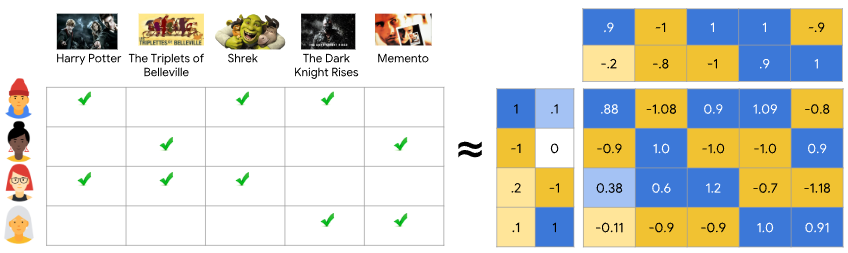


사용자 행렬: $N_{user}×Rank$ - 사용자 임베딩

아이템 행렬: $N_{item}×Rank$ - 아이템 임베딩

## 학습방법

### ALS(Alternating Least Square):

Loss: Mean Squared Error 

사용자의 평점은 아이템(영화)의 임베딩이 입력인 선형회귀모델로 나타냅니다, 이 때 사용자의 임베딩은 선형회귀모델의 계수가 됩니다.

아이템(영화)의 평점은 사용자의 임베딩이 입력인 선형회귀모델로 나타냅니다, 이 때 아이템(영화)의 임베딩은 선형회귀모델의 계수가 됩니다.

사용자의 임베딩은 아이템(영화)의 임베딩을 입력인 선형회귀모델의 학습을 통해 구합니다.

아이템(영화)의 임베딩은 사용자의 임베딩를 입력인 선형회귀모델의 학습을 통해 구합니다.

사용자 임베딩과 아이템 임베딩을 사용자 / 아이템 번갈아 가면서 

학습시킵니다.

(1) 사용자 / 아이템 임베딩 초기화

(2-1) 사용자 임베딩 학습을 통해 업데이트

(2-2) 아이템 임베딩 학습을 통해 업데이트

(3) (2)과정 사용자의 임베딩과 아이템의 임베딩이 반복

In [7]:
# ALS를 Demo를 위한 위에서 보인 케이스만을 취합니다.
df_ratings_toy = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
]
df_ratings_toy

,user id,item id,rating,date
233,303,69,5,1997-11-14 00:32:22
298,222,118,4,1997-10-22 23:43:22
356,13,56,5,1997-12-07 17:16:51
833,276,294,4,1997-09-20 20:12:46
2056,293,748,2,1998-03-03 05:52:07
2212,293,288,3,1998-03-03 05:52:07
2669,303,748,2,1997-11-14 00:10:14
3433,222,69,5,1997-10-30 03:32:18
4476,276,56,5,1997-09-20 21:40:23
5381,276,748,3,1998-01-03 10:15:07


1. 사용자 / 아이템 임베딩 초기화

$(0, \frac{1}{\sqrt{Rank}})$ 사이의 임의의 실수로 초기화합니다.

In [8]:
# 사용자와 아이템 행렬의 랭크를 3으로 합니다.
Rank = 3
# 동일한 결과를 얻기 위해 랜덤 시드값을 지정합니다.
np.random.seed(123)
# (0, 1/(Rank ** 0.5)) 사이의 난수를 사용자와 아이템의 임베딩 초기값으로 설정합니다.
df_user_emb = pd.DataFrame((np.random.random(size=(len(user_index), Rank))) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame((np.random.random(size=(len(item_index), Rank))) * 1 / np.sqrt(Rank), index=item_index)

2. 사용자 / 아이템 임베딩 학습

정규방정식을 이용하여 선형회귀모델을 학습시켜 계수를 구하여 임베딩을 업데이트 합니다.

$\hat{\beta} = (X^T X)^{-1} X^T y$

In [9]:
# 2-1 아이템 임베딩 학습

# 사용자 ID에 사용자 임베딩을 매핑시켜서 아이템 임베딩을 학습하기 위한 입력 변수를 만듭니다.
X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])

# OLS를 이용하여 아이템별 회귀계수를 구합니다.
df_item_emb_next = X_user.groupby(df_ratings_toy['item id']).apply(
    lambda x: pd.Series(
        np.dot(
            np.linalg.inv(np.dot(x.T, x)), 
            np.dot(x.T, df_ratings_toy.loc[x.index, 'rating'].values)
        )
    )
)
# 변경의 정도를 파악하기 위해 업데이트한 아이템 임베딩과 이전 임베딩 간의 차이의 제곱을 구합니다.
item_emb_diff = np.sum(np.sum(np.square(df_item_emb - df_item_emb_next), axis=0), axis=0)
# 업데이트 합니다.
df_item_emb = df_item_emb_next
df_item_emb

,0,1,2
item id,,,
56,8.441792,-5.314656,10.834095
69,7.943596,-7.600563,11.372707
118,3.735166,-0.854457,6.001115
288,4.897288,-1.753844,8.306465
294,0.751565,2.462693,7.714663
748,7.496543,-1.367724,1.478707


In [10]:
item_emb_diff

709.94497322885

In [11]:
# 2-2 사용자 임베딩 학습

# 아이템 ID에 아이템 임베딩을 매핑시켜서 사용자 임베딩을 학습하기 위한 입력 변수를 만듭니다.
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])

df_user_emb_next = X_item.groupby(df_ratings_toy['user id']).apply(
    lambda x: pd.Series(
        np.dot(
            np.linalg.inv(np.dot(x.T, x)), 
            np.dot(x.T, df_ratings_toy.loc[x.index, 'rating'].values)
        )
    )
)
user_emb_diff = np.sum(np.square(df_user_emb - df_user_emb_next), axis=0)
df_user_emb = df_user_emb_next
df_user_emb

,0,1,2
user id,,,
7,0.490103,0.001670,0.100558
13,0.556225,0.214729,0.094861
94,1.295394,0.573030,-0.262162
222,0.481467,0.282738,0.271434
276,0.401817,0.401532,0.338434
293,0.275759,0.162199,0.205936
303,0.187762,0.161659,0.398249
416,0.541358,0.480629,0.287306
682,0.394644,0.308655,0.261990


In [12]:
user_emb_diff

0    1.178474
1    0.140480
2    0.426382
dtype: float64

In [13]:
emb_diff = np.sum(item_emb_diff + user_emb_diff)
emb_diff

2131.5802558750847

3. 2의 과정을 반복

In [14]:
# 1~3을 종합
from sklearn.metrics import mean_squared_error

# Step 1
Rank = 3
np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3: 10회 반복
for epoch in range(10):
    # Step 2
    # 사용자 ID에 사용자 임베딩을 매핑시켜서 아이템 임베딩을 학습하기 위한 입력 변수를 만듭니다.
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])

    #OLS를 이용하여 아이템별 회귀계수를 구합니다.
    df_item_emb_next = X_user.groupby(df_ratings_toy['item id']).apply(
        lambda x: pd.Series(np.dot(np.linalg.inv(np.dot(x.T, x) + np.eye(Rank)), np.dot(x.T, df_ratings_toy.loc[x.index, 'rating'].values)))
    )
    item_emb_diff = np.sum(np.square(df_item_emb - df_item_emb_next), axis=0)
    df_item_emb = df_item_emb_next

    # 사용자 임베딩 학습
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    df_user_emb_next = X_item.groupby(df_ratings_toy['user id']).apply(
        lambda x: pd.Series(np.dot(np.linalg.inv(np.dot(x.T, x) + np.eye(Rank)), np.dot(x.T, df_ratings_toy.loc[x.index, 'rating'].values)))
    )
    user_emb_diff = np.sum(np.square(df_user_emb - df_user_emb_next), axis=0)
    df_user_emb = df_user_emb_next
    
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    emb_diff = np.sum(item_emb_diff + user_emb_diff, axis=0)
    print(epoch + 1, emb_diff, mse)

1 116.88860705768985 0.42212891626422144
2 7.197923718535307 0.18444164481454117
3 2.03017731084539 0.14082812676039416
4 0.749110526984072 0.13952165725911958
5 0.3965084781661494 0.140685083786656
6 0.2358085472976834 0.14220448858350504
7 0.1491508619883068 0.1437687750734252
8 0.09814891120065079 0.14528955451044892
9 0.06637253681298677 0.14673201354972212
10 0.04576134081369654 0.14807877315771031


In [15]:
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [16]:
# 사용자별 아이템에 대한 평점 예측을 합니다.
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

item id,Forrest Gump (1994),Liar Liar (1997),Pulp Fiction (1994),"Saint, The (1997)",Scream (1996),Twister (1996)
user id,,,,,,
19/M/student,4.417564,3.180632,4.786135,2.656661,4.350386,2.198396
20/F/student,4.222771,3.956971,4.957362,3.196127,4.525530,2.437956
21/M/student,4.100993,3.500169,4.872503,3.206675,3.907606,2.689122
23/M/programmer,3.796176,2.955034,4.298754,2.603551,3.664624,2.178289
24/M/writer,3.206634,2.103590,3.548231,2.057946,2.797630,1.875627
26/M/student,3.569097,2.737434,4.340265,2.965376,2.879100,2.735394
27/M/lawyer,4.583484,2.925954,5.000000,2.905485,3.944526,2.679336
29/M/programmer,4.723176,3.010760,5.000000,3.346799,3.705054,3.216542
47/M/educator,3.716257,2.039455,4.732905,3.462686,1.711764,3.778379


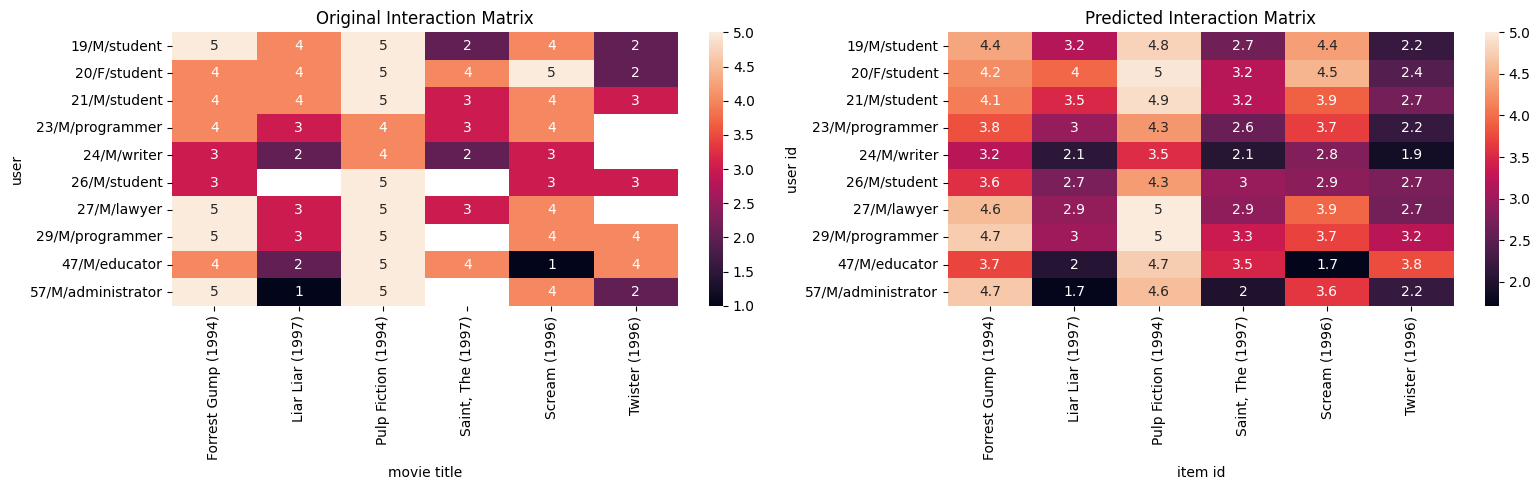

In [17]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heat을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_interaction,
    annot=True,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

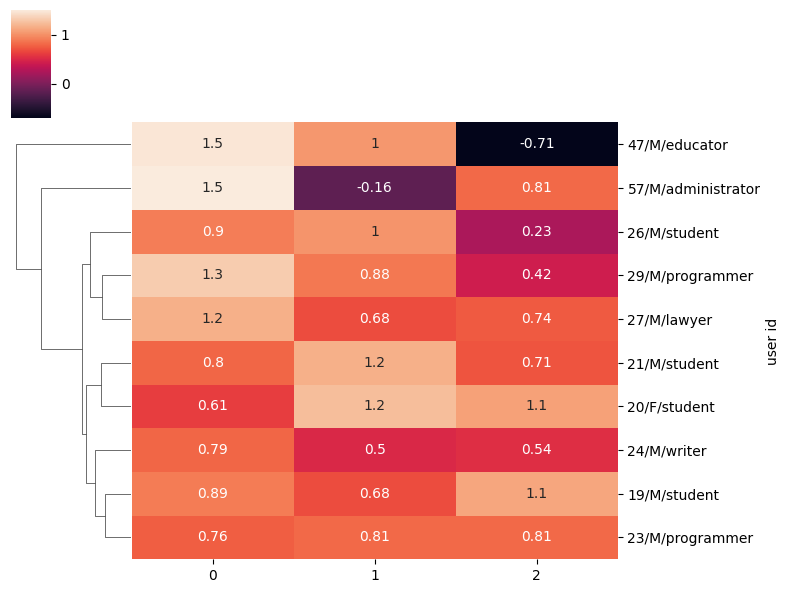

In [18]:
sns.clustermap(
    df_user_emb,
    annot=True,
    col_cluster=False,
    figsize=(8,6),
)
plt.show()

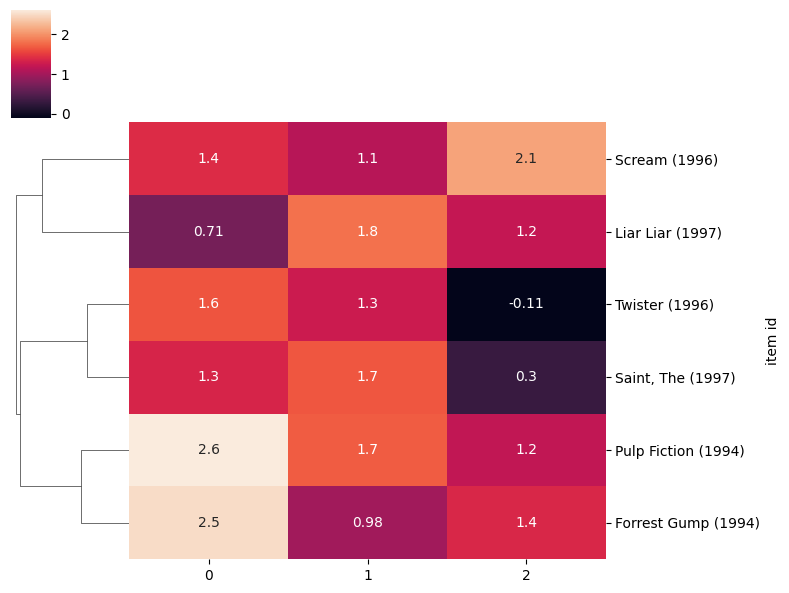

In [19]:
sns.clustermap(
    df_item_emb,
    annot=True,
    col_cluster=False,
    figsize=(8,6),
)
plt.show()

### 경사하강법(Gradient Descent)

$\hat{y} = User × Item^T$

$Loss = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$

$\frac{dLoss}{dUser_u} = -\frac{2}{n_u}\sum_{j∈u's Rating}{\left(y_{j} - \hat{y}_{j}\right)Item_j}$

$\frac{dLoss}{dItem_i} = -\frac{2}{n_i}\sum_{j∈i's Rating}{\left(y_{j} - \hat{y}_{j}\right)User_j}$

(1) 사용자 / 아이템 임베딩 초기화

(2-1) 경사 계산

(2-2) 임베딩 업데이트

(3) (2)과정 반복

In [20]:
# Step 1: 임베딩을 초기화 합니다.
Rank = 3 # 랭크는 3으로 합니다.
learning_rate = 0.1 # 학습율은 0.1로 합니다.

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

In [21]:
# Step 2-1: 경사(기울기)를 계산합니다.

X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
y_hat = (X_user * X_item).sum(axis=1)
err = df_ratings_toy['rating'] - y_hat

X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))

In [22]:
# Step 2-2: 계산한 경사로 임베딩을 업데이트 합니다.

df_user_emb -= X_user_g * learning_rate
df_item_emb -= X_item_g * learning_rate

* 1~3 과정을 통합하여 루틴을 구성합니다.

In [23]:
# Step 1
Rank = 3
learning_rate = 0.1

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3
for epoch in range(10):
    # Step 2-1

    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    y_hat = (X_user * X_item).sum(axis=1)
    err = df_ratings_toy['rating'] - y_hat

    X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    
    # Step 2-2

    df_user_emb -= X_user_g * learning_rate
    df_item_emb -= X_item_g * learning_rate
    
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    print(epoch + 1, mse, learning_rate)
    

1 12.726392723476021 0.1
2 11.316646866625875 0.1
3 9.165112472561301 0.1
4 6.315758754884341 0.1
5 3.4077815231901107 0.1
6 1.4448711658176128 0.1
7 0.6935668946300555 0.1
8 0.5353135883232235 0.1
9 0.5092269448492088 0.1
10 0.5022433460159583 0.1


In [24]:
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [25]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)

In [26]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

item id,Forrest Gump (1994),Liar Liar (1997),Pulp Fiction (1994),"Saint, The (1997)",Scream (1996),Twister (1996)
user id,,,,,,
19/M/student,4.288070,3.019673,4.971112,3.155516,3.719919,2.936183
20/F/student,4.700032,3.224169,5.000000,3.374686,4.061221,3.077677
21/M/student,4.438304,3.103900,5.000000,3.215283,3.832533,2.976655
23/M/programmer,4.070629,2.803929,4.631799,2.927556,3.516523,2.678523
24/M/writer,3.243109,2.217255,3.675980,2.334239,2.806900,2.123189
26/M/student,3.812238,2.696743,4.433734,2.812614,3.307262,2.626073
27/M/lawyer,4.502347,3.123682,5.000000,3.285047,3.905229,3.022157
29/M/programmer,4.666335,3.313020,5.000000,3.456957,4.051571,3.236411
47/M/educator,3.867430,2.692748,4.449027,2.831112,3.356284,2.611624


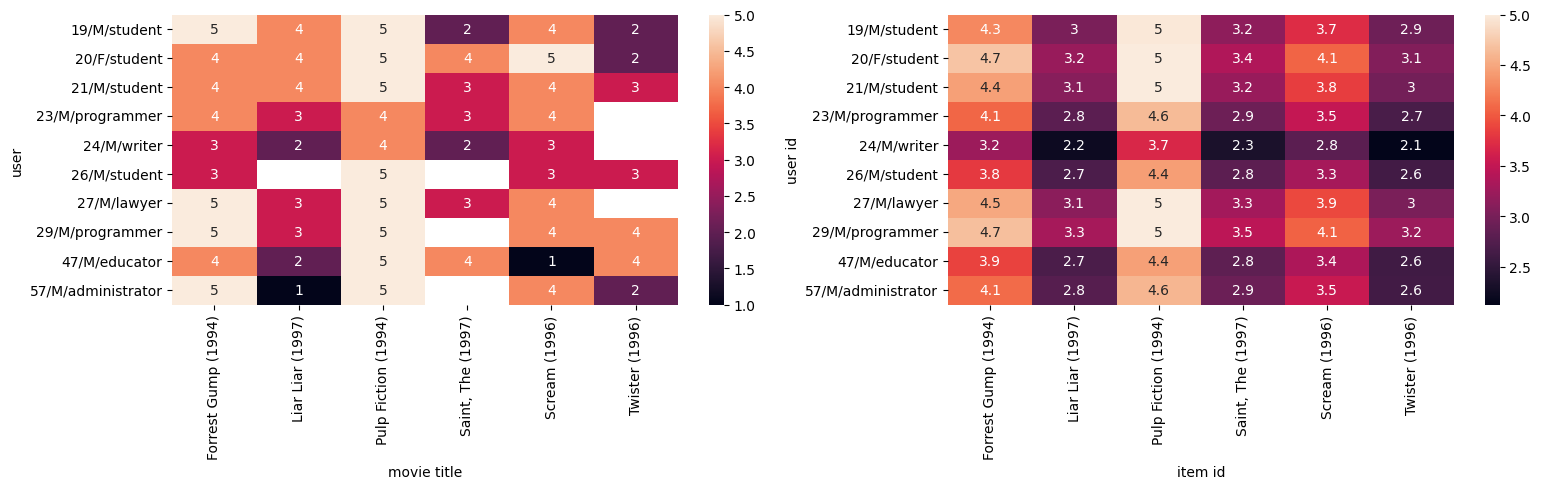

In [27]:
# 원래값과 예측값을 비교합니다.

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_interaction,
    annot=True,
    ax=axes[0]
)

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True,
    ax=axes[1]
)

plt.tight_layout()
plt.show()

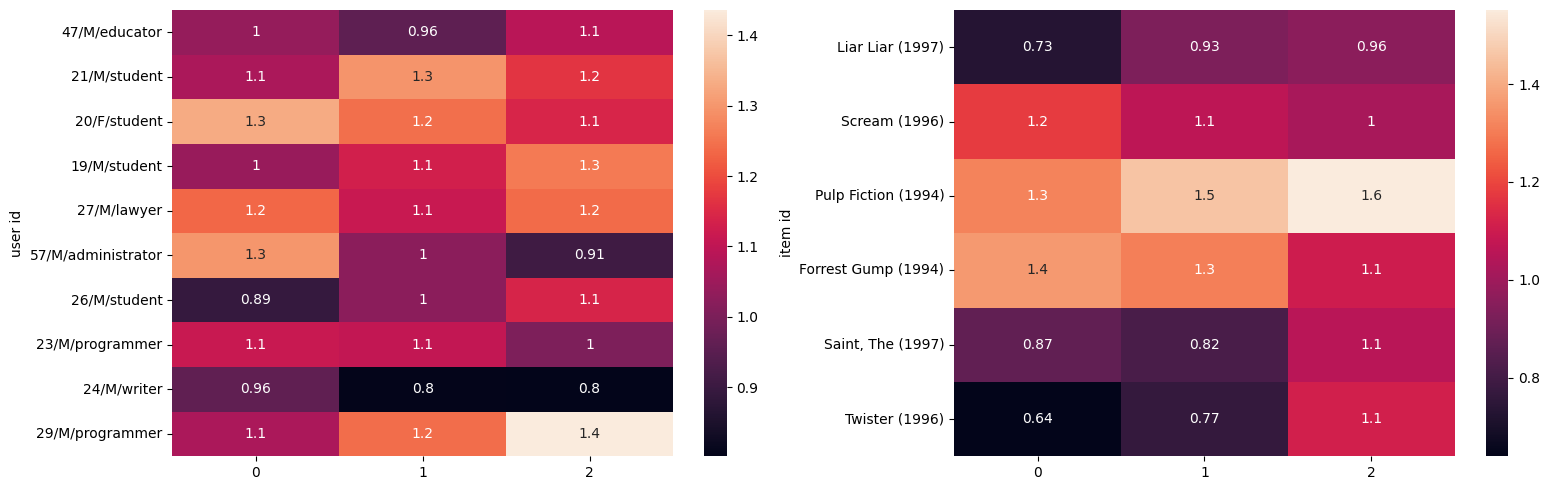

In [28]:
# 임베딩을 출력합니다.

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_user_emb,
    annot=True,
    ax=axes[0]
)

sns.heatmap(
    df_item_emb,
    annot=True,
    ax=axes[1]
)

plt.tight_layout()
plt.show()

## Tensorflow로 MovieLens100K 학습하기

$\hat{r}_{ui} =  \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$

$\bar{r_u}$: 사용자의 상대적 평균(다른 사용자에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$\bar{r_i}$: 아이템의 상대적 평균(다른 아이템에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

ue: User Embedding, ie: Item Embedding

In [29]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [31]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ratings, train_size=0.8, random_state=123, shuffle=True)

In [32]:
df_train['user id'].value_counts()

user id
405    593
655    537
13     489
450    443
276    423
      ... 
876     14
812     14
685     14
147     14
866     13
Name: count, Length: 943, dtype: int64

In [33]:
ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [43]:
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


**Matrix Factorization**

In [45]:
# 모델에서 사용하는 요소들을 Eager Execution 모드에서 제작합니다.
# 모델을 만드는 게 훨씬 수월해집니다.

# user id를 위치 Index로 바꿔주는 레이어입니다. 
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['user id'].unique())
)
# 사용자 임베딩 레이어입니다.
emb_user = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 8
)

# item id를 위치 Index로 바꿔주는 레이어입니다. 
lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['item id'].unique())
)
# 아이템 임베딩 레이어입니다.
emb_movie = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 8
)

# Row-wise (axes=-1) Dot Product 레이어입니다.
dot = tf.keras.layers.Dot(axes=-1)

# user id를 임베딩에서의 위치 인덱스로 가져옵니다.
uid = lu_userid(tf.constant([1, 2, 0, -1, 5]))
# item id를 임베딩에서의 위치 인덱스로 가져옵니다.
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))
# 위치 인덱스에 해당하는 사용자 임베딩을 가져옵니다.
x_uid = emb_user(uid)
# 위치 인덱스에 해당하는 영화 임베딩을 가져옵니다.
x_mid = emb_movie(mid)

# 결과를 출력합니다.
x_uid, x_mid, dot([x_uid, x_mid])

(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.00411825, -0.03570869,  0.03182868, -0.03860091, -0.00244759,
          0.02462483, -0.02963125, -0.03893534],
        [-0.02262455, -0.03638943,  0.04631999, -0.04562849, -0.0150332 ,
         -0.01051847,  0.02078159, -0.04574864],
        [-0.02594923,  0.00316445,  0.03608586,  0.00169986, -0.03075084,
          0.02536817, -0.04585635, -0.01334285],
        [-0.02594923,  0.00316445,  0.03608586,  0.00169986, -0.03075084,
          0.02536817, -0.04585635, -0.01334285],
        [ 0.04717859, -0.00200224,  0.00584354,  0.0098836 , -0.03456162,
         -0.00677722,  0.03490454,  0.04350907]], dtype=float32)>,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[-0.00312018,  0.0481487 , -0.0460392 ,  0.03101667,  0.00842017,
         -0.01750934,  0.01242384, -0.0337786 ],
        [-0.03219068,  0.02814813, -0.04204381,  0.03656933, -0.04319249,
         -0.03269845,  0.03588921, -0.02803451],
        [-0.02780586,  

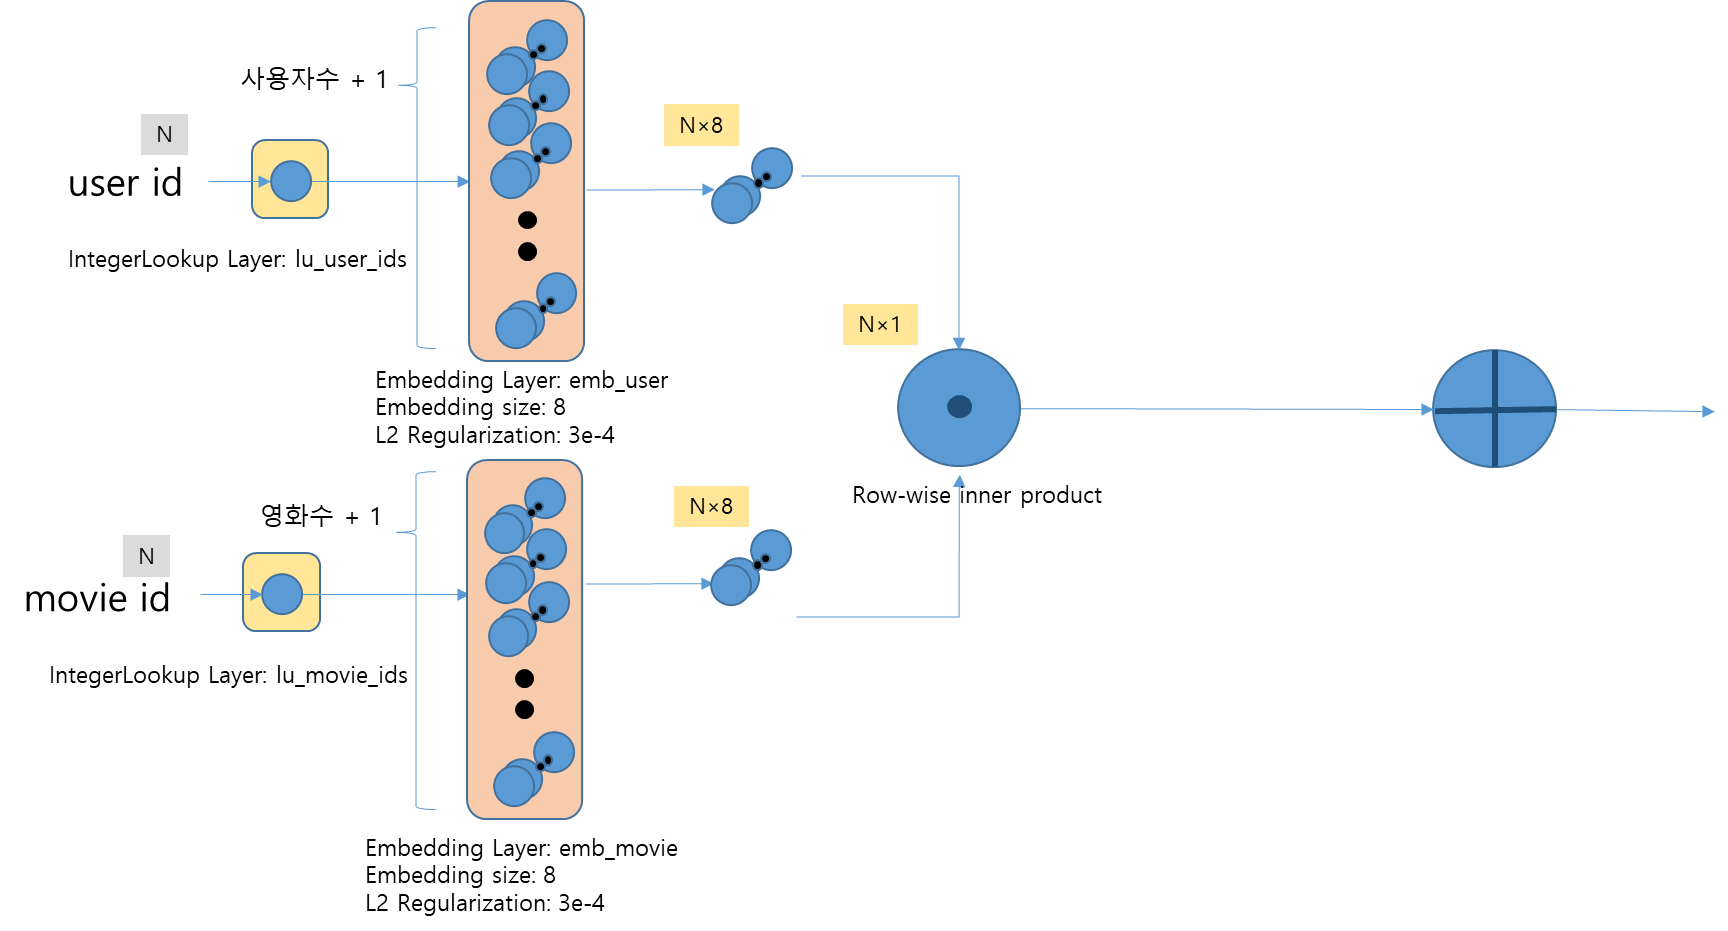

**Mean Model**

In [44]:
# 전체 평균을 구합니다.
mean = tf.constant([df_train['rating'].mean()], dtype=tf.float32)
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['user id'].unique())
)
# 사용자의 평균을 저장하는 임베딩입니다.
emb_user_mean = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 1
)

lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary=tf.constant(df_train['item id'].unique())
)
# 영화의 평균을 저장하는 임베딩입니다.
emb_movie_mean = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 1
)

uid = lu_userid(tf.constant([1, 2, 0, 1, 5]))
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))

x_uid = emb_user_mean(uid)
x_mid = emb_movie_mean(mid)

x_uid, x_mid, x_uid + x_mid + mean

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.03397368],
        [-0.03387447],
        [ 0.01855257],
        [ 0.03397368],
        [ 0.02792293]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.01182581],
        [-0.04077637],
        [ 0.03777098],
        [-0.01180201],
        [-0.02172852]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[3.575662 ],
        [3.4552116],
        [3.586186 ],
        [3.5520341],
        [3.5360568]], dtype=float32)>)

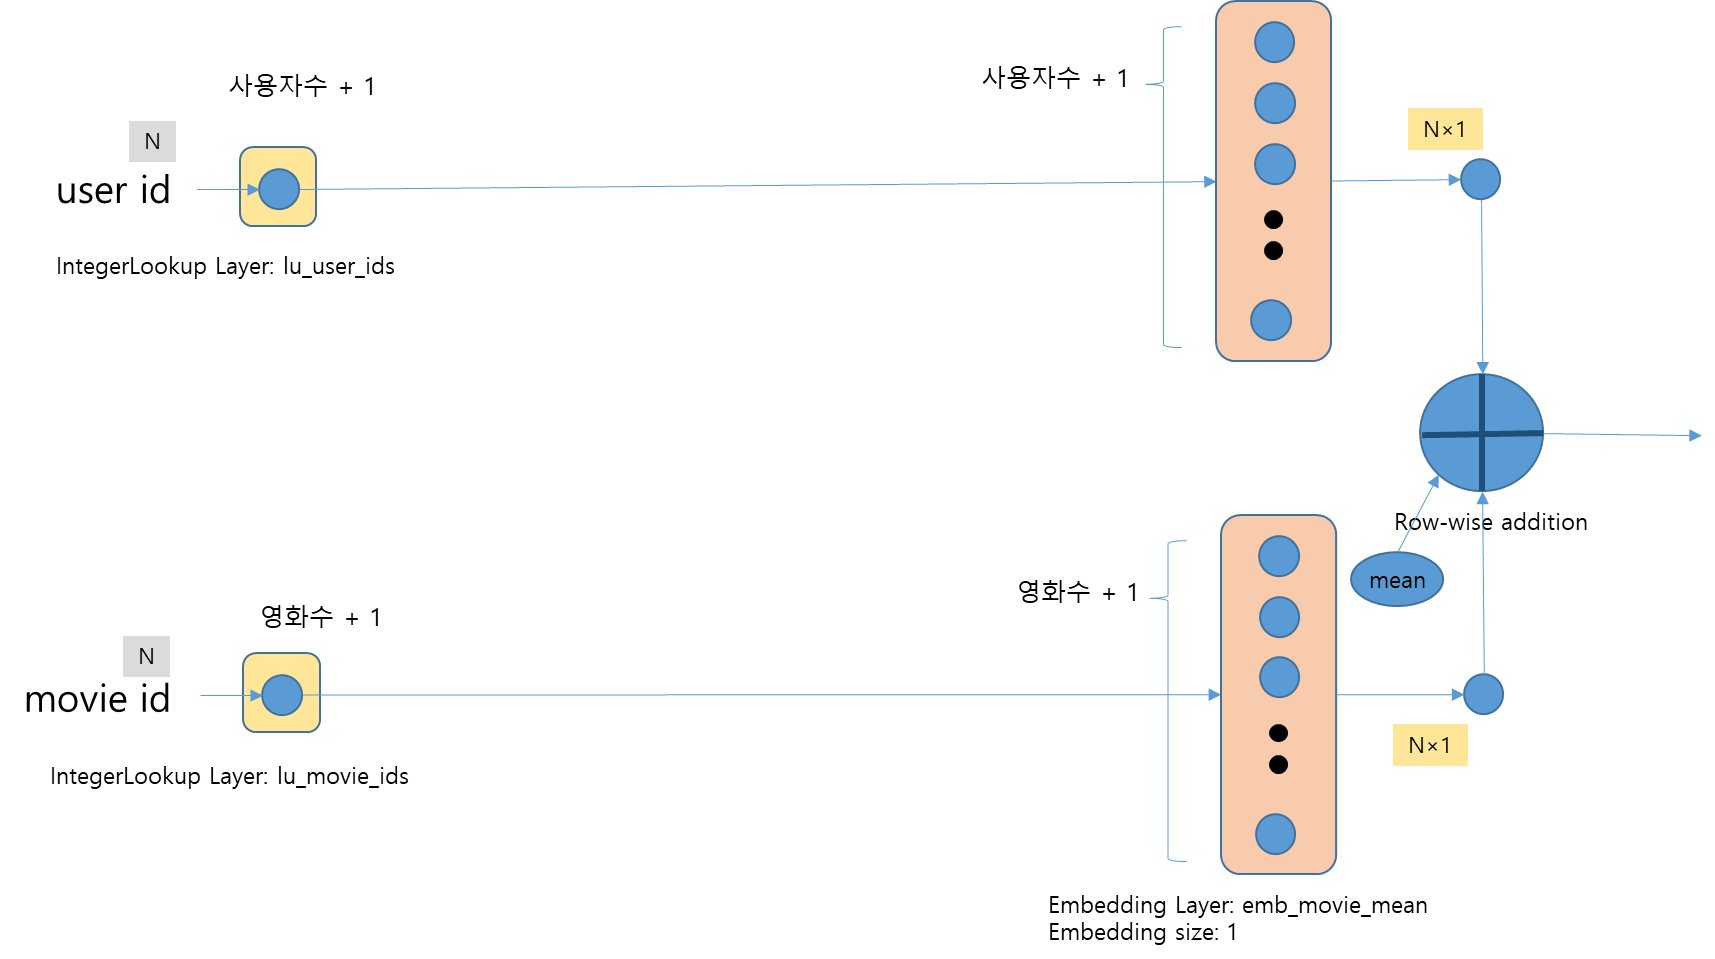

**Matrix Factorization augumented user/item mean Model Architecture**

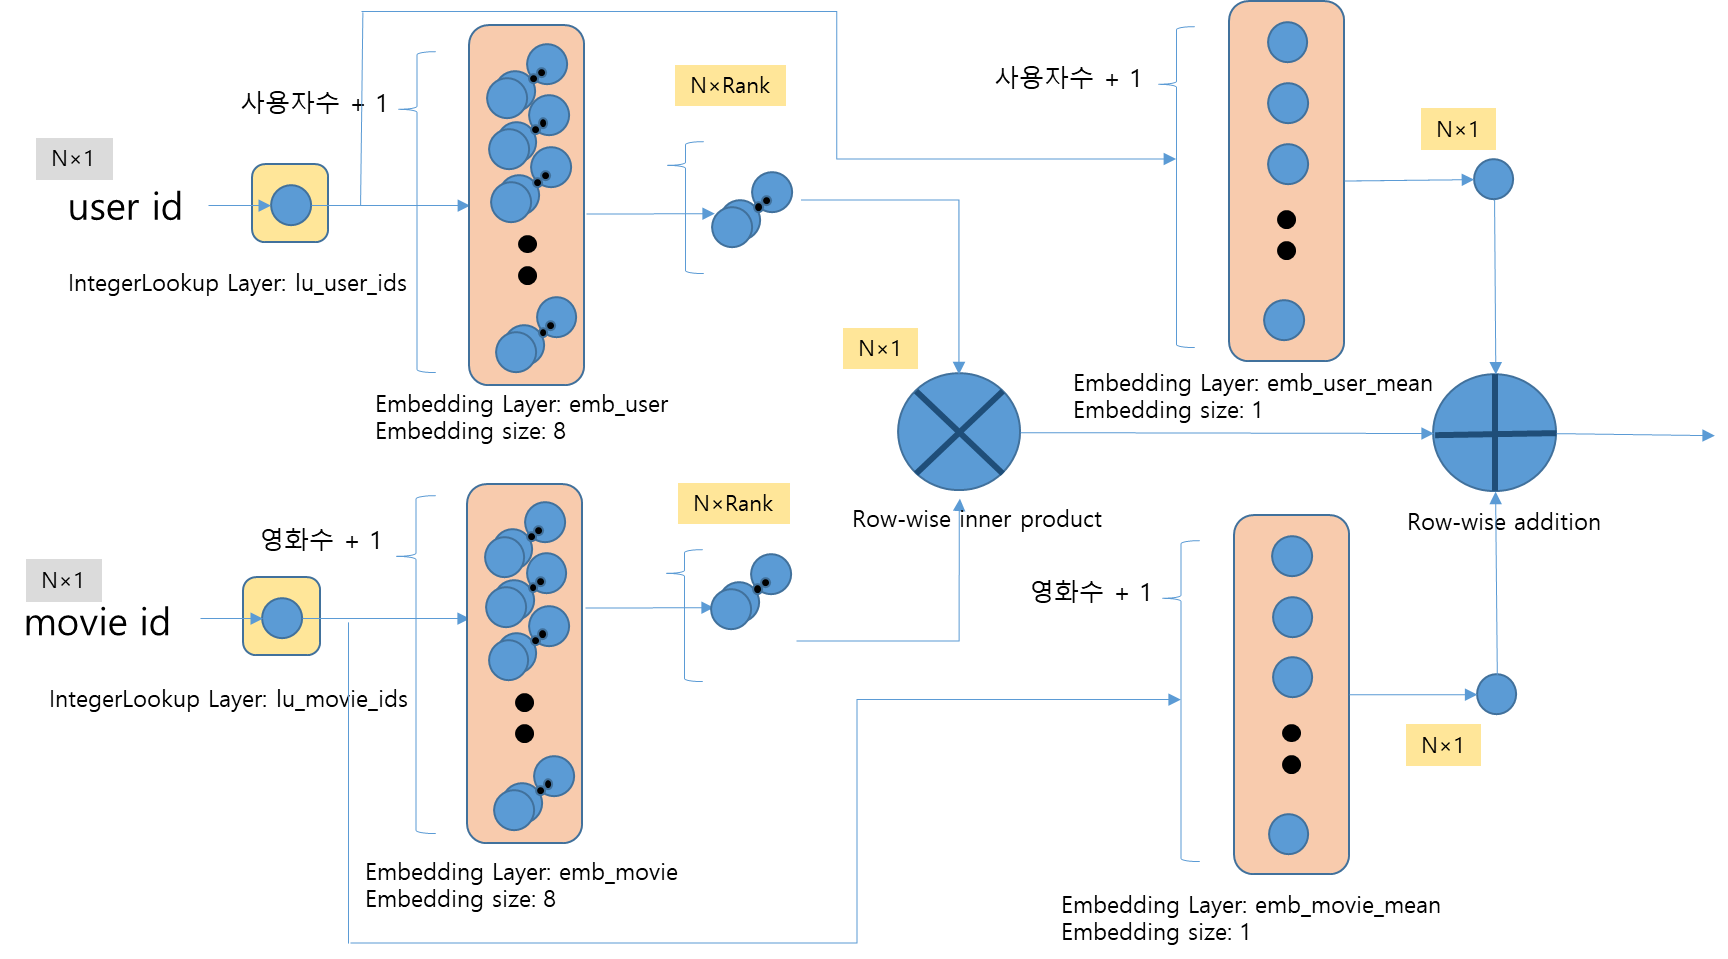

In [46]:
class MF_Mean_Model(tf.keras.Model):
    def __init__(self, user_ids, item_ids, rank):
        super().__init__()
        # user id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_user = tf.keras.layers.IntegerLookup(vocabulary=user_ids)
        # item id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_item = tf.keras.layers.IntegerLookup(vocabulary=item_ids)
        
        # user id에 대한 상대적 평균을 나타내는 임베딩입니다.
        self.emb_user_mean = tf.keras.layers.Embedding(len(user_ids) + 1, 1)
        # item id에 대한 상대적 평균을 나타내는 임베딩입니다. 
        self.emb_item_mean = tf.keras.layers.Embedding(len(item_ids) + 1, 1)
        
        # 사용자 행렬을 나타내는 사용자 임베딩입니다. embedding_regularizer를 두어 Overfitting을 방지합니다.
        self.emb_user = tf.keras.layers.Embedding(len(user_ids) + 1, rank, embeddings_regularizer=tf.keras.regularizers.L2(1.5e-4))
        # 아이템 행렬을 나타내는 아이템 임베딩입니다. embedding_regularizer를 두어 Overfitting을 방지합니다.
        self.emb_item = tf.keras.layers.Embedding(len(item_ids) + 1, rank, embeddings_regularizer=tf.keras.regularizers.L2(1.5e-4))
        
        # 맵핑된 사용자 임베딩과 맵핑된 아이템 임베딩을 Row-wise inner product 연산을 해주는 layer입니다. 
        self.dot = tf.keras.layers.Dot(axes=-1)
        
    def call(self, x, training=False):
        x_user = self.lu_user(x['user id']) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        user_mean = self.emb_user_mean(x_user) # 사용자의 상대적 평균을 가져옵니다. user_mean: N×1 실수
        
        x_item = self.lu_item(x['item id']) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec = self.emb_item(x_item) # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        item_mean = self.emb_item_mean(x_item) # 아이템의 상대적 평균을 가져옵니다.
        
        return user_mean + item_mean + self.dot([user_vec, item_vec])
    
    def predict_by_userid(self, user_id, item_ids):
        x_user = self.lu_user(user_id) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] 단일 정수 / x_user: 단일 정수 정수
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. emb_user: rank개의 실수
        
        x_item = self.lu_item(item_ids) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N개의 정수 / x_item: N개의 정수
        return tf.squeeze(
            tf.matmul(
                tf.expand_dims(user_vec, axis=0), 
                tf.transpose(self.emb_item(x_item))
            ) + 
            tf.squeeze(
                self.emb_item_mean(x_item)
            ) + 
            self.emb_user_mean(x_user)
        )

In [47]:
mf_mean_model = MF_Mean_Model(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 사용자 ID를 전달합니다. 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 아이템 ID를 전달합니다.
    16
)

In [48]:
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004), # Adam Optimizer를 사용합니다.
    loss=tf.keras.losses.MeanSquaredError(), # 손실은 MSE를 사용합니다.
    metrics=tf.keras.metrics.MeanSquaredError() # 지표는 MSE로 합니다.
)

In [49]:
mf_mean_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(256), epochs=20)

Epoch 1/20
313/313 [==============================] - 7s 19ms/step - loss: 6.2066 - mean_squared_error: 5.9567 - val_loss: 1.7085 - val_mean_squared_error: 1.1547
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 1.6050 - mean_squared_error: 1.0083 - val_loss: 1.5894 - val_mean_squared_error: 0.9776
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.5459 - mean_squared_error: 0.9408 - val_loss: 1.5592 - val_mean_squared_error: 0.9632
Epoch 4/20
313/313 [==============================] - 2s 7ms/step - loss: 1.5104 - mean_squared_error: 0.9283 - val_loss: 1.5236 - val_mean_squared_error: 0.9555
Epoch 5/20
313/313 [==============================] - 2s 5ms/step - loss: 1.4701 - mean_squared_error: 0.9156 - val_loss: 1.4890 - val_mean_squared_error: 0.9502
Epoch 6/20
313/313 [==============================] - 2s 5ms/step - loss: 1.4288 - mean_squared_error: 0.9034 - val_loss: 1.4457 - val_mean_squared_error: 0.9375
Epoch 7/20
313/313 [=======

In [40]:
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='logs/m100k/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index:
        f.write("{}\n".format(df_movie.loc[i, 'movie title']))

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights =  tf.Variable(mf_mean_model.emb_item.get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [41]:
%tensorboard --logdir logs/m100k/ --bind_all

In [42]:
# 1번 사용자에 대해 영화 번호 [1, 2, 3]에 대한 예측을 해봅니다.
mf_model.predict_by_userid(1, [1, 2, 3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([4.205759 , 3.2464037, 2.8037598], dtype=float32)>

## NNModel

**Neural Networks Architecture**

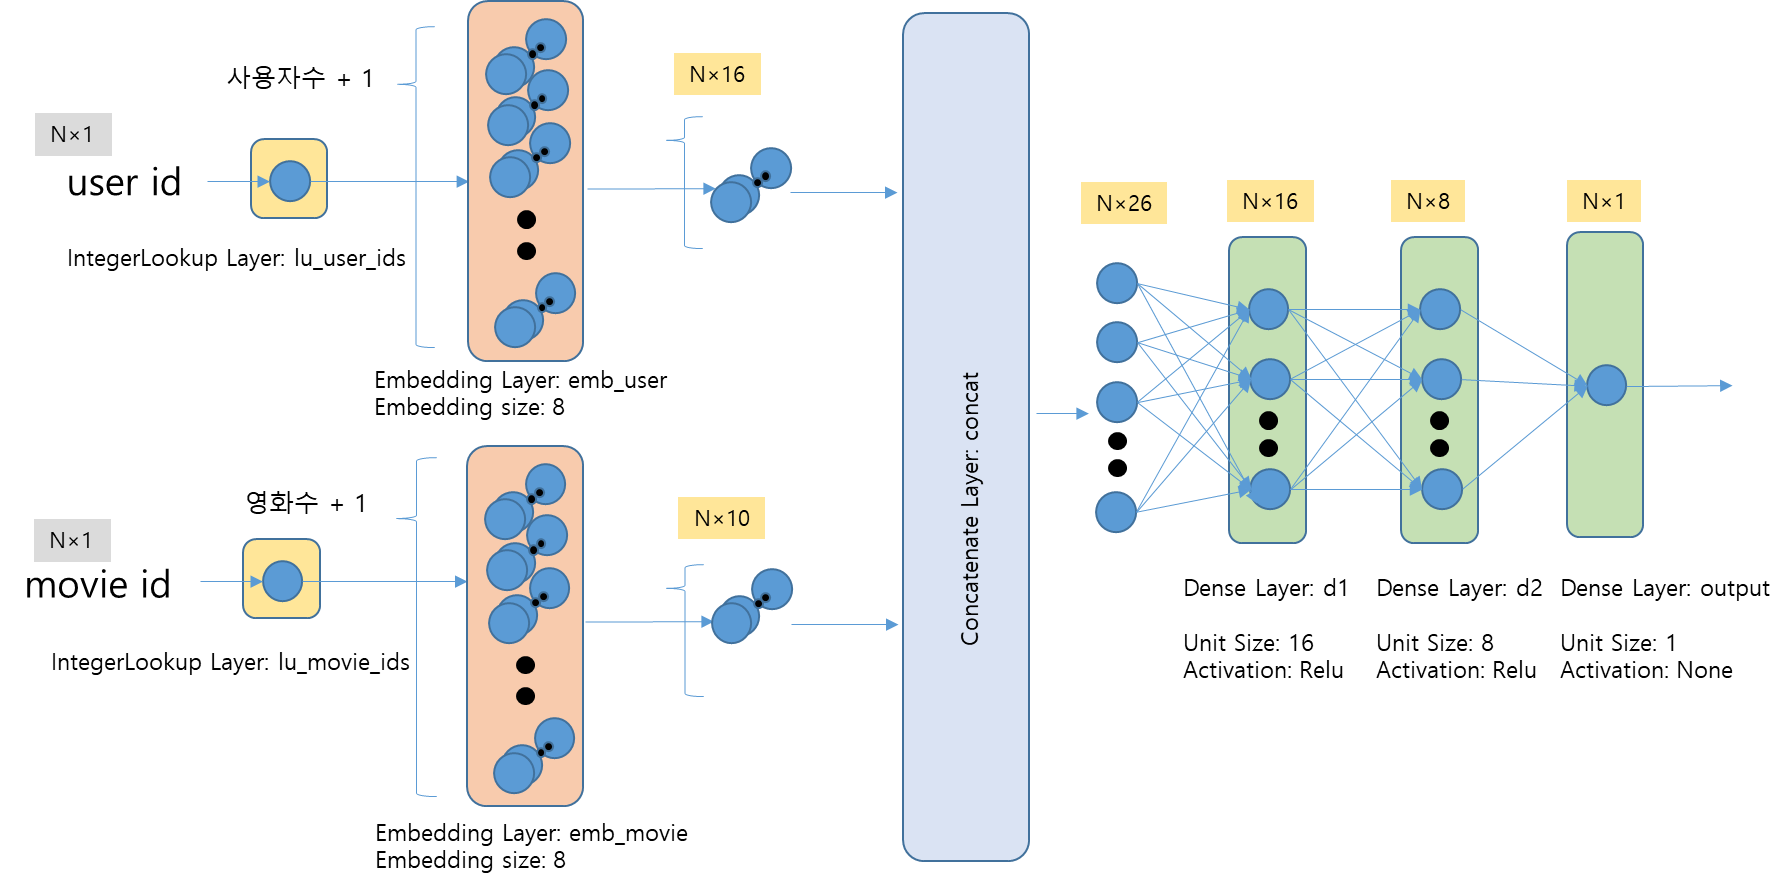

In [52]:
class NNModel(tf.keras.Model):
    def __init__(self, user_ids, item_ids, emb_user_size, emb_item_size):
        super().__init__()
        self.lu_user = tf.keras.layers.IntegerLookup(vocabulary=user_ids)
        self.lu_item = tf.keras.layers.IntegerLookup(vocabulary=item_ids)
        
        self.emb_user =  tf.keras.layers.Embedding(len(user_ids) + 1, emb_user_size, embeddings_regularizer=tf.keras.regularizers.L2(3e-4))
        self.emb_item =  tf.keras.layers.Embedding(len(item_ids) + 1, emb_item_size, embeddings_regularizer=tf.keras.regularizers.L2(3e-4))
        
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        
        self.dl1 = tf.keras.layers.Dense(16, activation='relu')
        self.dl2 = tf.keras.layers.Dense(8, activation='relu')
        self.o = tf.keras.layers.Dense(1)
    def call(self, x, training=False):
        x_user = self.lu_user(x['user id'])
        x_user = self.emb_user(x_user)
        x_item = self.lu_item(x['item id'])
        x_item = self.emb_item(x_item)
        y = self.cc([x_user, x_item])
        y = self.dl1(y)
        y = self.dl2(y)
        return self.o(y)

In [53]:
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


In [54]:
nn_model = NNModel(
    df_train['user id'].pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    df_train['item id'].pipe(lambda x: x.loc[x > 20]).index.tolist(), 16, 10)

In [55]:
tf.keras.backend.clear_session()
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)
nn_model.fit(ds_train.shuffle(10000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20
313/313 [==============================] - 23s 68ms/step - loss: 4.5058 - mean_squared_error: 4.4600 - val_loss: 1.0707 - val_mean_squared_error: 1.0447
Epoch 2/20
313/313 [==============================] - 21s 67ms/step - loss: 1.0083 - mean_squared_error: 0.9809 - val_loss: 1.0244 - val_mean_squared_error: 0.9960
Epoch 3/20
313/313 [==============================] - 21s 66ms/step - loss: 0.9868 - mean_squared_error: 0.9583 - val_loss: 1.0213 - val_mean_squared_error: 0.9926
Epoch 4/20
313/313 [==============================] - 21s 67ms/step - loss: 0.9840 - mean_squared_error: 0.9554 - val_loss: 1.0212 - val_mean_squared_error: 0.9928
Epoch 5/20
313/313 [==============================] - 21s 67ms/step - loss: 0.9822 - mean_squared_error: 0.9541 - val_loss: 1.0217 - val_mean_squared_error: 0.9938
Epoch 6/20
313/313 [==============================] - 21s 66ms/step - loss: 0.9815 - mean_squared_error: 0.9539 - val_loss: 1.0195 - val_mean_squared_error: 0.9922
Epoch 7/20
313/3

**VS Neural Network**

**Matrix Factorization**: 사용자 한 명의 영화에 대한 예측은 한 번의 모델 실행으로 구할 수 있습니다.

따라서, Matrix Factorization은 Neural Network 보다 서비스 시 더 빠릅니다.

※ Google에서 개발한 ScaNN과 같은 알고리즘 이 과정을 보다 최적화시켜 줍니다.

하지만, Matrix는 사용자와 아이템을 동일한 사이즈(Rank)로 구성해야 하는 구조적 제약을 가지고 있어

Neural Network에 비해 제약적인 구성을 가지고 있습니다. 

이로 인해 정교한 모델링이 Neural Network보다 어렵습니다.

이 둘을 활용하는 전략에 대해 아래 논문이 자세히 다루고 있습니다.

[Youtube Recommender](https://github.com/Dryjelly/Youtube_Recommendation_tf_keras)

논문의 골자: 

Matrix Factorization은 추천 아이템을 1차적으로 후보 대상을 선정하여 예측 대상을 줄이고,

Nerual Network을 통해 정교한 예측 결과로 순위를 메기는 구조로

추천 시스템을 구성한다는 것입니다.

In [50]:
%%timeit
mf_model.predict_by_userid(1,  tf.constant(df_movie.index))

3.07 ms ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Neural Network**: 사용자 한 명의 영화에 대한 예측을 구하려면 예측할 영화의 개수 만큼 모델을 실행해야 합니다.

In [56]:
%%timeit
X = tf.data.Dataset.from_tensor_slices({
    'user id': [1] * len(df_movie),
    'item id': df_movie.index.tolist()
}).batch(2048)

nn_model.predict(X, verbose=0)

10.6 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


* 하지만 구조상 User와 Item 을 동일한 수의 임베딩으로 모델링해야 한다는 구조적 제약이 있어 Neural Network 보다는 모델 유연한 구성이 힘듭니다

# 문제점

Matrix Factorization 모델 뿐만 아니라, 데이터 기반의 방법에서의 문제점이기도 합니다.

## 1. Cold Start Problem

데이터가 확보되지 않은 사용자나 아이템에 대한 예측의 정확도가 떨어집니다.

In [57]:
# 시점을 기준으로 나누어 Test에는 Train에 등장하지 않은 사용자와 영화가 배치되도록 합니다.
df_train = df_ratings.query('date < "1998-03-01"')
df_test = df_ratings.query('date >= "1998-03-01"')

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [58]:
# Train에 등장하지 않은 사용자의 출연 빈도를 봅니다.
df_test['user id'].value_counts().pipe(lambda x: x.loc[~x.isin(df_train['user id'].unique())])

user id
234    480
796    358
551    334
334    333
393    234
      ... 
661      3
577      3
561      3
483      3
453      3
Name: count, Length: 75, dtype: int64

In [59]:
mf_model = MFModel(df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 
                   df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 16)
tf.keras.backend.clear_session()
mf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)

In [60]:
mf_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20
305/305 [==============================] - 8s 25ms/step - loss: 6.2057 - mean_squared_error: 5.9785 - val_loss: 1.7414 - val_mean_squared_error: 1.2336
Epoch 2/20
305/305 [==============================] - 2s 6ms/step - loss: 1.5418 - mean_squared_error: 0.9910 - val_loss: 1.6741 - val_mean_squared_error: 1.1093
Epoch 3/20
305/305 [==============================] - 2s 6ms/step - loss: 1.4844 - mean_squared_error: 0.9238 - val_loss: 1.6632 - val_mean_squared_error: 1.1104
Epoch 4/20
305/305 [==============================] - 2s 7ms/step - loss: 1.4532 - mean_squared_error: 0.9117 - val_loss: 1.6462 - val_mean_squared_error: 1.1141
Epoch 5/20
305/305 [==============================] - 2s 5ms/step - loss: 1.4183 - mean_squared_error: 0.9010 - val_loss: 1.6261 - val_mean_squared_error: 1.1200
Epoch 6/20
305/305 [==============================] - 1s 3ms/step - loss: 1.3813 - mean_squared_error: 0.8894 - val_loss: 1.5791 - val_mean_squared_error: 1.0997
Epoch 7/20
305/305 [=======

In [61]:
s_mse = df_test.assign(
    rating_hat = np.squeeze(mf_model.predict(ds_test.batch(1024)))
).groupby('user id').apply(lambda x: mean_squared_error(x['rating'], x['rating_hat'])).rename('mse')

22/22 [==============================] - 0s 1ms/step


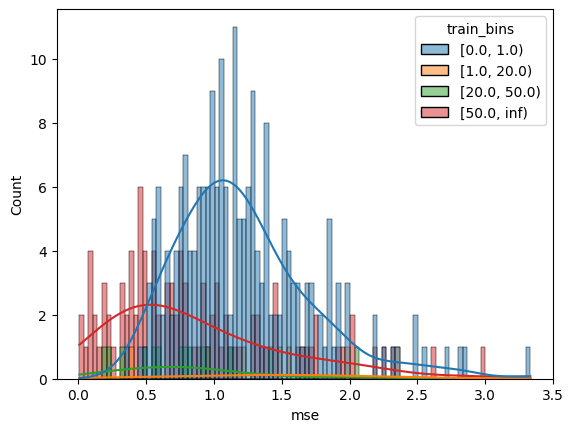

In [62]:
pd.concat([
    df_train['user id'].value_counts().rename('train count'),
    df_test['user id'].value_counts().rename('test count'), s_mse
], axis=1).pipe(lambda x: x.loc[x['test count'].notna()]).fillna(0)\
.assign(
    train_bins = lambda x: pd.cut(x['train count'], bins=[0, 1, 20, 50, np.inf], right=False)
).pipe(lambda x: sns.histplot(data=x, x='mse', hue='train_bins', bins=100, kde=True))
plt.show()

## 2. 지속적인 재학습 필요

사용자, 아이템이 추가될 때마다, 모델을 재구성해줘야 하고

새로운 데이터로 재학습을 시켜줘야합니다.

이후 챕터에서는 이를 극복하기 위한 방법을 소개드립니다.